<h1>Aim 2</h1>
<h3>WIDS 2024 Challenge ++</h3>
<h3>BMI 212 - Team DMMTS</h3>

In [2]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn import preprocessing

<h4> Load the data</h4>

In [3]:
# Load the CSV dataset
nonimpute_raw_df = pd.read_csv('../Data/train_test_added_climate_data.csv')
impute_raw_df = pd.read_csv('../Data/train_test_added_climate_data_imputed.csv')

# Rename feature columns for better readability
columns_dict = {'bmi': 'patient_bmi',
                   'region': 'patient_region',
                   'division': 'patient_division',
                   'side': 'patient_tumor_side',
                   'quadrant': 'patient_tumor_quadrant',
                   'metastatic_organ': 'patient_metastatic_organ',
                   'cleaned_metastatic_first_treatment': 'patient_metastatic_first_treatment',
                   'cleaned_metastatic_first_treatment_type': 'patient_metastatic_first_treatment_type',
                   'population': 'population_size',
                   'density': 'population_density',
                   'age_median': 'population_age_median',
                   'female': 'population_female_perc',
                   'married': 'population_married_perc',
                   'divorced': 'population_divorced_perc',
                   'never_married': 'population_never_married_perc',
                   'widowed': 'population_widowed_perc',
                   'family_size': 'population_family_size',
                   'family_dual_income': 'population_family_dual_income_perc',
                   'income_individual_median': 'population_income_individual_median',
                   'income_household_median': 'population_income_household_median',
                   'home_ownership': 'population_home_ownership_perc',
                   'home_value': 'population_home_value',
                   'rent_median': 'population_rent_median',
                   'rent_burden': 'population_rent_burden_perc',
                   'education_less_highschool': 'population_education_less_highschool_perc',
                   'education_highschool': 'population_education_highschool_perc',
                   'education_some_college': 'population_education_some_college_perc',
                   'education_bachelors': 'population_education_bachelors_perc',
                   'education_graduate': 'population_education_graduate_perc',
                   'education_college_or_above': 'population_education_college_or_above_perc',
                   'education_stem_degree': 'population_education_stem_degree_perc',
                   'unemployment_rate': 'population_unemployment_rate',
                   'self_employed': 'population_self_employed_perc',
                   'farmer': 'population_farmer_perc',
                   'race_white': 'population_race_white_perc',
                   'race_black': 'population_race_black_perc',
                   'race_asian': 'population_race_asian_perc',
                   'race_native': 'population_race_native_american_perc',
                   'race_pacific': 'population_race_pacific_islander_perc',
                   'race_other': 'population_race_other_perc',
                   'race_multiple': 'population_race_multiple_perc',
                   'hispanic': 'population_hispanic_perc',
                   'disabled': 'population_disabled_perc',
                   'poverty': 'population_poverty_perc',
                   'limited_english': 'population_limited_english_perc',
                   'commute_time': 'population_commute_time',
                   'health_uninsured': 'population_health_uninsured_perc',
                   'veteran': 'population_veteran_perc',
                   'climate_ozone': 'annual_ozone_conc',
                   'climate_pm25': 'annual_fine_particulate_matter_conc',
                   'climate_n02': 'annual_nitrogen_dioxide_conc',
                   'Ozone': 'annual_ozone_conc',
                   'PM25': 'annual_fine_particulate_matter_conc',
                   'N02': 'annual_nitrogen_dioxide_conc'}

nonimpute_raw_df.rename(columns=columns_dict, inplace=True)
impute_raw_df.rename(columns=columns_dict, inplace=True)

<h4>Select the features to use</h4>

In [4]:
features = ['patient_race', 'payer_type', 'patient_state', 'patient_age', 'patient_gender', 'patient_bmi',
            'patient_region', 'patient_division', 'patient_tumor_side', 'patient_tumor_quadrant',
            'patient_metastatic_organ', 'patient_metastatic_first_treatment', 'patient_metastatic_first_treatment_type',
            'population_size', 'population_density', 'population_age_median', 'population_female_perc',
            'population_married_perc', 'population_divorced_perc', 'population_never_married_perc',
            'population_widowed_perc', 'population_family_size', 'population_family_dual_income_perc',
            'population_income_individual_median', 'population_income_household_median', 'population_home_ownership_perc',
            'population_home_value', 'population_rent_median', 'population_rent_burden_perc',
            'population_education_less_highschool_perc', 'population_education_highschool_perc',
            'population_education_some_college_perc', 'population_education_bachelors_perc',
            'population_education_graduate_perc', 'population_education_college_or_above_perc',
            'population_education_stem_degree_perc', 'population_unemployment_rate', 'population_self_employed_perc',
            'population_farmer_perc', 'population_race_white_perc', 'population_race_black_perc',
            'population_race_asian_perc', 'population_race_native_american_perc', 'population_race_pacific_islander_perc',
            'population_race_other_perc', 'population_race_multiple_perc', 'population_hispanic_perc',
            'population_disabled_perc', 'population_poverty_perc', 'population_limited_english_perc',
            'population_commute_time', 'population_health_uninsured_perc', 'population_veteran_perc', 'annual_nitrogen_dioxide_conc',
            'annual_fine_particulate_matter_conc', 'annual_ozone_conc']

# Select only rows where allocated_set is train
nonimpute_train_df = nonimpute_raw_df[nonimpute_raw_df['allocated_set'] == 'train']
impute_train_df = impute_raw_df[impute_raw_df['allocated_set'] == 'train']

# Select the features to use
nonimpute_df = nonimpute_train_df[features]
impute_df = impute_train_df[features]

# Extract labels for time to treatment 
labels_df = nonimpute_train_df[['treatment_pd']]

<h4>Define categorical variables</h4>

In [6]:
# Convert object features to categorical
for col in nonimpute_df.select_dtypes(include='object').columns:
    nonimpute_df[col] = nonimpute_df[col].astype('category')
    impute_df[col] = impute_df[col].astype('category')

# List of categorical features
categorical_features = list(nonimpute_df.select_dtypes(include='category').columns)
print(categorical_features)

['patient_race', 'payer_type', 'patient_state', 'patient_gender', 'patient_region', 'patient_division', 'patient_tumor_side', 'patient_tumor_quadrant', 'patient_metastatic_organ', 'patient_metastatic_first_treatment', 'patient_metastatic_first_treatment_type']


In [7]:
# Note: Significant portion of race data is missing! Double-check that they have been imputed.
impute_df['patient_race'].value_counts(dropna=False)

White       14577
Black        4713
Other        3917
Hispanic     3173
Asian        1294
Name: patient_race, dtype: int64

<h4>Drop low-variance features</h4>

In [8]:
# Temporarily convert categorical features to distinct numerical codes, keeping missing/NaN values
temp_nonimpute_df = nonimpute_df.copy()
temp_impute_df = impute_df.copy()

for cat_feat in categorical_features:
    temp_nonimpute_df[cat_feat] = temp_nonimpute_df[cat_feat].cat.codes
    temp_impute_df[cat_feat] = temp_impute_df[cat_feat].cat.codes

    temp_nonimpute_df.loc[temp_nonimpute_df[cat_feat] == -1] = np.NaN
    temp_impute_df.loc[temp_impute_df[cat_feat] == -1] = np.NaN

In [9]:
temp_impute_df.head()

,patient_race,payer_type,patient_state,patient_age,patient_gender,patient_bmi,patient_region,patient_division,patient_tumor_side,patient_tumor_quadrant,...,population_hispanic_perc,population_disabled_perc,population_poverty_perc,population_limited_english_perc,population_commute_time,population_health_uninsured_perc,population_veteran_perc,annual_nitrogen_dioxide_conc,annual_fine_particulate_matter_conc,annual_ozone_conc
0,0.0,0.0,4.0,46.0,0.0,27.00,3.0,5.0,1.0,7.0,...,47.726087,9.895652,10.515217,12.745652,32.530435,7.263043,3.810870,20.084231,9.595719,47.310325
1,4.0,2.0,35.0,63.0,0.0,27.82,0.0,0.0,0.0,3.0,...,1.182979,18.317021,13.546809,0.146809,31.890909,7.631915,9.631915,12.485563,8.399666,40.544389
2,2.0,0.0,44.0,53.0,0.0,27.12,2.0,8.0,0.0,2.0,...,21.064151,14.083019,11.943396,2.549057,32.556250,16.396226,10.392453,11.522807,9.361774,38.696786
3,2.0,1.0,4.0,50.0,0.0,26.42,3.0,5.0,2.0,8.0,...,37.948485,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,20.113179,8.487175,42.301121
4,3.0,0.0,34.0,39.0,0.0,18.00,1.0,2.0,2.0,8.0,...,18.960526,10.194737,18.642105,14.173684,42.502632,6.392105,1.755263,27.496367,7.879795,37.722740


In [69]:
from sklearn.feature_selection import VarianceThreshold

# Remove low-var features from temp df (will drop removed cols from original df)
low_var_filter_nonimpute = VarianceThreshold(threshold=(.9 * (1 - .9)))
filtered_features_nonimpute = low_var_filter_nonimpute.fit_transform(temp_nonimpute_df)
filtered_feature_names_nonimpute = low_var_filter_nonimpute.get_feature_names_out(input_features=features)
print("Non-imputed Low-variance features: ", set(features) - set(filtered_feature_names_nonimpute))

low_var_filter_impute = VarianceThreshold(threshold=(.9 * (1 - .9)))
filtered_features_impute = low_var_filter_impute.fit_transform(temp_impute_df)
filtered_feature_names_impute = low_var_filter_impute.get_feature_names_out(input_features=features)
print("Imputed Low-variance features: ", set(features) - set(filtered_feature_names_impute))

nonimpute_df_filtered = nonimpute_df[filtered_feature_names_nonimpute].copy()
impute_df_filtered = impute_df[filtered_feature_names_impute].copy()

Non-imputed Low-variance features:  {'patient_gender', 'population_family_size', 'patient_metastatic_first_treatment_type'}
Imputed Low-variance features:  {'patient_gender', 'population_family_size', 'patient_metastatic_first_treatment_type'}


# Categorize label to 30/60/90 day treatment

In [70]:
# Rename dfs of features and target
X_nonimpute = nonimpute_df_filtered
X_impute = impute_df_filtered
y = labels_df

y_30 = y['treatment_pd'].apply(lambda x: 1 if x <= 30 else 0)

y_60 = y['treatment_pd'].apply(lambda x: 1 if x <= 60 else 0)

y_90 = y['treatment_pd'].apply(lambda x: 1 if x <= 90 else 0)

# Split into train/test 80/20

In [71]:
# Split the data into train/test split (80/20) - preserve class counts between splits
X_train_nonimpute_30, X_test_nonimpute_30, y_train_30, y_test_30 = train_test_split(X_nonimpute, y_30, test_size=0.2, random_state=123, stratify=y_30)
X_train_impute_30, X_test_impute_30, y_train_30, y_test_30 = train_test_split(X_impute, y_30, test_size=0.2, random_state=123, stratify=y_30)
print(y_train_30.value_counts())
print(y_test_30.value_counts())

X_train_nonimpute_60, X_test_nonimpute_60, y_train_60, y_test_60 = train_test_split(X_nonimpute, y_60, test_size=0.2, random_state=123, stratify=y_60)
X_train_impute_60, X_test_impute_60, y_train_60, y_test_60 = train_test_split(X_impute, y_60, test_size=0.2, random_state=123, stratify=y_60)
print(y_train_60.value_counts())
print(y_test_60.value_counts())

X_train_nonimpute_90, X_test_nonimpute_90, y_train_90, y_test_90 = train_test_split(X_nonimpute, y_90, test_size=0.2, random_state=123, stratify=y_90)
X_train_impute_90, X_test_impute_90, y_train_90, y_test_90 = train_test_split(X_impute, y_90, test_size=0.2, random_state=123, stratify=y_90)
print(y_train_90.value_counts())
print(y_test_90.value_counts())

0    17714
1     4425
Name: treatment_pd, dtype: int64
0    4429
1    1106
Name: treatment_pd, dtype: int64
0    12685
1     9454
Name: treatment_pd, dtype: int64
0    3171
1    2364
Name: treatment_pd, dtype: int64
1    13549
0     8590
Name: treatment_pd, dtype: int64
1    3387
0    2148
Name: treatment_pd, dtype: int64


# Non-Imputed - LightGBM

<h4>Non-imputed 30-day classification</h4>

In [57]:
# Create the LightGBM dataset
train_nonimpute_data_30 = lgb.Dataset(X_train_nonimpute_30, label=y_train_30, feature_name='auto', categorical_feature=categorical_features)
test_nonimpute_data_30 = lgb.Dataset(X_test_nonimpute_30, label=y_test_30, feature_name='auto', categorical_feature=categorical_features)

# Define the hyperparameters for a classification model
params = {
    'objective': ['binary'],
    'metric': ['auc'], 
    'is_unbalance': [True],
    'boosting_type': ['dart'], 
    'n_estimators': [50, 100],
    'num_leaves': [31, 63],
    'learning_rate': [0.05, 0.1],
    'colsample_bytree': [0.9],
    'subsample': [0.9],
    'subsample_freq': [10],
    'verbose': [-1],
}

# Train the model
model_nonimpute_30 = lgb.LGBMClassifier()

# Create the grid search
grid_nonimpute_30 = GridSearchCV(model_nonimpute_30, params, cv=10, scoring='roc_auc')

# Fit the model to the data
grid_nonimpute_30.fit(X_train_nonimpute_30, y_train_30)

GridSearchCV(cv=10, estimator=LGBMClassifier(),
             param_grid={'boosting_type': ['dart'], 'colsample_bytree': [0.9],
                         'is_unbalance': [True], 'learning_rate': [0.05, 0.1],
                         'metric': ['auc'], 'n_estimators': [50, 100],
                         'num_leaves': [31, 63], 'objective': ['binary'],
                         'subsample': [0.9], 'subsample_freq': [10],
                         'verbose': [-1]},
             scoring='roc_auc')

In [58]:
# Print best parameters
print('Best parameters:', grid_nonimpute_30.best_params_)

# Print best in-sample score
print('Insample AUC:', grid_nonimpute_30.best_score_)

# Test the model
y_test_pred_nonimpute_lgb_30 = grid_nonimpute_30.predict_proba(X_test_nonimpute_30)[:,1]

# Calculate AUC
fpr, tpr, thresholds = roc_curve(y_test_30, y_test_pred_nonimpute_lgb_30)

# Print AUC
print('AUC:', auc(fpr, tpr))

Best parameters: {'boosting_type': 'dart', 'colsample_bytree': 0.9, 'is_unbalance': True, 'learning_rate': 0.05, 'metric': 'auc', 'n_estimators': 50, 'num_leaves': 31, 'objective': 'binary', 'subsample': 0.9, 'subsample_freq': 10, 'verbose': -1}
Insample AUC: 0.7014288752157013
AUC: 0.7092010695575806


<h4>Non-imputed 60-day classification</h4>

In [59]:
# Create the LightGBM dataset
train_nonimpute_data_60 = lgb.Dataset(X_train_nonimpute_60, label=y_train_60, feature_name='auto', categorical_feature=categorical_features)
test_nonimpute_data_60 = lgb.Dataset(X_test_nonimpute_60, label=y_test_60, feature_name='auto', categorical_feature=categorical_features)

# Define the hyperparameters for a classification model
params = {
    'objective': ['binary'],
    'metric': ['auc'], 
    'is_unbalance': [True],
    'boosting_type': ['dart'], 
    'n_estimators': [50, 100],
    'num_leaves': [31, 63],
    'learning_rate': [0.05, 0.1],
    'colsample_bytree': [0.9],
    'subsample': [0.9],
    'subsample_freq': [10],
    'verbose': [-1],
}

# Train the model
model_nonimpute_60 = lgb.LGBMClassifier()

# Create the grid search
grid_nonimpute_60 = GridSearchCV(model_nonimpute_60, params, cv=10, scoring='roc_auc')

# Fit the model to the data
grid_nonimpute_60.fit(X_train_nonimpute_60, y_train_60)

GridSearchCV(cv=10, estimator=LGBMClassifier(),
             param_grid={'boosting_type': ['dart'], 'colsample_bytree': [0.9],
                         'is_unbalance': [True], 'learning_rate': [0.05, 0.1],
                         'metric': ['auc'], 'n_estimators': [50, 100],
                         'num_leaves': [31, 63], 'objective': ['binary'],
                         'subsample': [0.9], 'subsample_freq': [10],
                         'verbose': [-1]},
             scoring='roc_auc')

In [60]:
# Print best parameters
print('Best parameters:', grid_nonimpute_60.best_params_)

# Print best in-sample score
print('Insample AUC:', grid_nonimpute_60.best_score_)

# Test the model
y_test_pred_nonimpute_lgb_60 = grid_nonimpute_60.predict_proba(X_test_nonimpute_60)[:,1]

# Calculate AUC
fpr, tpr, thresholds = roc_curve(y_test_60, y_test_pred_nonimpute_lgb_60)

# Print AUC
print('AUC:', auc(fpr, tpr))

Best parameters: {'boosting_type': 'dart', 'colsample_bytree': 0.9, 'is_unbalance': True, 'learning_rate': 0.1, 'metric': 'auc', 'n_estimators': 50, 'num_leaves': 31, 'objective': 'binary', 'subsample': 0.9, 'subsample_freq': 10, 'verbose': -1}
Insample AUC: 0.724464975601192
AUC: 0.7238690469520469


<h4>Non-imputed 90-day classification</h4>

In [61]:
# Create the LightGBM dataset
train_nonimpute_data_90 = lgb.Dataset(X_train_nonimpute_90, label=y_train_90, feature_name='auto', categorical_feature=categorical_features)
test_nonimpute_data_90 = lgb.Dataset(X_test_nonimpute_90, label=y_test_90, feature_name='auto', categorical_feature=categorical_features)

# Define the hyperparameters for a classification model
params = {
    'objective': ['binary'],
    'metric': ['auc'], 
    'is_unbalance': [True],
    'boosting_type': ['dart'], 
    'n_estimators': [50, 100],
    'num_leaves': [31, 63],
    'learning_rate': [0.05, 0.1],
    'colsample_bytree': [0.9],
    'subsample': [0.9],
    'subsample_freq': [10],
    'verbose': [-1],
}

# Train the model
model_nonimpute_90 = lgb.LGBMClassifier()

# Create the grid search
grid_nonimpute_90 = GridSearchCV(model_nonimpute_90, params, cv=10, scoring='roc_auc')

# Fit the model to the data
grid_nonimpute_90.fit(X_train_nonimpute_90, y_train_90)

GridSearchCV(cv=10, estimator=LGBMClassifier(),
             param_grid={'boosting_type': ['dart'], 'colsample_bytree': [0.9],
                         'is_unbalance': [True], 'learning_rate': [0.05, 0.1],
                         'metric': ['auc'], 'n_estimators': [50, 100],
                         'num_leaves': [31, 63], 'objective': ['binary'],
                         'subsample': [0.9], 'subsample_freq': [10],
                         'verbose': [-1]},
             scoring='roc_auc')

In [66]:
# Print best parameters
print('Best parameters:', grid_nonimpute_90.best_params_)

# Print best in-sample score
print('Insample AUC:', grid_nonimpute_90.best_score_)

# Test the model
y_test_pred_nonimpute_lgb_90 = grid_nonimpute_90.predict_proba(X_test_nonimpute_90)[:,1]

# Calculate AUC
fpr, tpr, thresholds = roc_curve(y_test_90, y_test_pred_nonimpute_lgb_90)

# Print AUC
print('AUC:', auc(fpr, tpr))

Best parameters: {'boosting_type': 'dart', 'colsample_bytree': 0.9, 'is_unbalance': True, 'learning_rate': 0.1, 'metric': 'auc', 'n_estimators': 100, 'num_leaves': 31, 'objective': 'binary', 'subsample': 0.9, 'subsample_freq': 10, 'verbose': -1}
Insample AUC: 0.764468057788723
AUC: 0.7722348265550337


# Imputed - LightGBM

<h4>Imputed 30-day classification</h4>

In [78]:
# Create the LightGBM dataset
train_data_30 = lgb.Dataset(X_train_impute_30, label=y_train_30, feature_name='auto', categorical_feature=categorical_features)
test_data_30 = lgb.Dataset(X_test_impute_30, label=y_test_30, feature_name='auto', categorical_feature=categorical_features)

# Define the hyperparameters for a classification model
params = {
    'objective': ['binary'],
    'metric': ['auc'], 
    'is_unbalance': [True],
    'boosting_type': ['dart'], 
    'n_estimators': [50, 100],
    'num_leaves': [31, 63],
    'learning_rate': [0.05, 0.1],
    'colsample_bytree': [0.9],
    'subsample': [0.9],
    'subsample_freq': [10],
    'verbose': [-1],
}

# Train the model
model_impute_30 = lgb.LGBMClassifier()

# Create the grid search
grid_impute_30 = GridSearchCV(model_impute_30, params, cv=10, scoring='roc_auc')

# Fit the model to the data
grid_impute_30.fit(X_train_impute_30, y_train_30)

GridSearchCV(cv=10, estimator=LGBMClassifier(),
             param_grid={'boosting_type': ['dart'], 'colsample_bytree': [0.9],
                         'is_unbalance': [True], 'learning_rate': [0.05, 0.1],
                         'metric': ['auc'], 'n_estimators': [50, 100],
                         'num_leaves': [31, 63], 'objective': ['binary'],
                         'subsample': [0.9], 'subsample_freq': [10],
                         'verbose': [-1]},
             scoring='roc_auc')

In [79]:
# Print best parameters
print('Best parameters:', grid_impute_30.best_params_)

# Print best in-sample score
print('Insample AUC:', grid_impute_30.best_score_)

# Test the model
y_test_pred_impute_lgb_30 = grid_impute_30.predict_proba(X_test_impute_30)[:,1]

# Calculate AUC
fpr, tpr, thresholds = roc_curve(y_test_30, y_test_pred_impute_lgb_30)

# Print AUC
print('AUC:', auc(fpr, tpr))

Best parameters: {'boosting_type': 'dart', 'colsample_bytree': 0.9, 'is_unbalance': True, 'learning_rate': 0.05, 'metric': 'auc', 'n_estimators': 50, 'num_leaves': 31, 'objective': 'binary', 'subsample': 0.9, 'subsample_freq': 10, 'verbose': -1}
Insample AUC: 0.7001098101655292
AUC: 0.7138134243439896


<h4>Imputed 60-day classification</h4>

In [80]:
# Create the LightGBM dataset
train_data_60 = lgb.Dataset(X_train_impute_60, label=y_train_60, feature_name='auto', categorical_feature=categorical_features)
test_data_60 = lgb.Dataset(X_test_impute_60, label=y_test_60, feature_name='auto', categorical_feature=categorical_features)

# Define the hyperparameters for a classification model
params = {
    'objective': ['binary'],
    'metric': ['auc'], 
    'is_unbalance': [True],
    'boosting_type': ['dart'], 
    'n_estimators': [50, 100],
    'num_leaves': [31, 63],
    'learning_rate': [0.05, 0.1],
    'colsample_bytree': [0.9],
    'subsample': [0.9],
    'subsample_freq': [10],
    'verbose': [-1],
}

# Train the model
model_impute_60 = lgb.LGBMClassifier()

# Create the grid search
grid_impute_60 = GridSearchCV(model_impute_60, params, cv=10, scoring='roc_auc')

# Fit the model to the data
grid_impute_60.fit(X_train_impute_60, y_train_60)

GridSearchCV(cv=10, estimator=LGBMClassifier(),
             param_grid={'boosting_type': ['dart'], 'colsample_bytree': [0.9],
                         'is_unbalance': [True], 'learning_rate': [0.05, 0.1],
                         'metric': ['auc'], 'n_estimators': [50, 100],
                         'num_leaves': [31, 63], 'objective': ['binary'],
                         'subsample': [0.9], 'subsample_freq': [10],
                         'verbose': [-1]},
             scoring='roc_auc')

In [81]:
# Print best parameters
print('Best parameters:', grid_impute_60.best_params_)

# Print best score
print('Insample AUC:', grid_impute_60.best_score_)

# Test the model
y_test_pred_impute_lgb_60 = grid_impute_60.predict_proba(X_test_impute_60)[:,1]

# Calculate AUC
fpr, tpr, thresholds = roc_curve(y_test_60, y_test_pred_impute_lgb_60)

# Print AUC
print('AUC:', auc(fpr, tpr))

Best parameters: {'boosting_type': 'dart', 'colsample_bytree': 0.9, 'is_unbalance': True, 'learning_rate': 0.05, 'metric': 'auc', 'n_estimators': 100, 'num_leaves': 31, 'objective': 'binary', 'subsample': 0.9, 'subsample_freq': 10, 'verbose': -1}
Insample AUC: 0.7238419066035159
AUC: 0.7239783016668081


<h4>Imputed 90-day classification</h4>

In [82]:
# Create the LightGBM dataset
train_data_90 = lgb.Dataset(X_train_impute_90, label=y_train_90, feature_name='auto', categorical_feature=categorical_features)
test_data_90 = lgb.Dataset(X_test_impute_90, label=y_test_90, feature_name='auto', categorical_feature=categorical_features)

# Define the hyperparameters for a classification model
params = {
    'objective': ['binary'],
    'metric': ['auc'], 
    'is_unbalance': [True],
    'boosting_type': ['dart'], 
    'n_estimators': [50, 100],
    'num_leaves': [31, 63],
    'learning_rate': [0.05, 0.1],
    'colsample_bytree': [0.9],
    'subsample': [0.9],
    'subsample_freq': [10],
    'verbose': [-1],
}

# Train the model
model_impute_90 = lgb.LGBMClassifier()

# Create the grid search
grid_impute_90 = GridSearchCV(model_impute_90, params, cv=10, scoring='roc_auc')

# Fit the model to the data
grid_impute_90.fit(X_train_impute_90, y_train_90)

GridSearchCV(cv=10, estimator=LGBMClassifier(),
             param_grid={'boosting_type': ['dart'], 'colsample_bytree': [0.9],
                         'is_unbalance': [True], 'learning_rate': [0.05, 0.1],
                         'metric': ['auc'], 'n_estimators': [50, 100],
                         'num_leaves': [31, 63], 'objective': ['binary'],
                         'subsample': [0.9], 'subsample_freq': [10],
                         'verbose': [-1]},
             scoring='roc_auc')

In [83]:
# Print best parameters
print('Best parameters:', grid_impute_90.best_params_)

# Print best score
print('Best score:', grid_impute_90.best_score_)

# Test the model
y_test_pred_impute_lgb_90 = grid_impute_90.predict_proba(X_test_impute_90)[:,1]

# Calculate AUC
fpr, tpr, thresholds = roc_curve(y_test_90, y_test_pred_impute_lgb_90)

# Print AUC
print('AUC:', auc(fpr, tpr))

Best parameters: {'boosting_type': 'dart', 'colsample_bytree': 0.9, 'is_unbalance': True, 'learning_rate': 0.1, 'metric': 'auc', 'n_estimators': 100, 'num_leaves': 31, 'objective': 'binary', 'subsample': 0.9, 'subsample_freq': 10, 'verbose': -1}
Best score: 0.7634485049136333
AUC: 0.770795087361634


## Imputed - Lasso/Logistic Reg/Random Forest

In [84]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [85]:
# Note: Looks like we need to on-hot-encode categorical features for RandomForestRegressor to work
# 30-day train/test sets
onehot_feat_train_impute_30 = pd.get_dummies(X_train_impute_30, dummy_na = False)
onehot_feat_test_impute_30 = pd.get_dummies(X_test_impute_30, dummy_na = False)

# 60-day train/test sets
onehot_feat_train_impute_60 = pd.get_dummies(X_train_impute_60, dummy_na = False)
onehot_feat_test_impute_60 = pd.get_dummies(X_test_impute_60, dummy_na = False)

# 90-day train/test sets
onehot_feat_train_impute_90 = pd.get_dummies(X_train_impute_90, dummy_na = False)
onehot_feat_test_impute_90 = pd.get_dummies(X_test_impute_90, dummy_na = False)

<h4>Random Forest 30-days classification</h4>

In [86]:
rand_forest_30 = RandomForestClassifier()

# Fit the model to the data
rand_forest_30.fit(onehot_feat_train_impute_30, y_train_30.values.ravel())

# Test the model
y_test_pred_impute_rf_30 = rand_forest_30.predict_proba(onehot_feat_test_impute_30)[:, 1]

# Print AUROC
print('AUROC:', roc_auc_score(y_true=y_test_30, y_score=y_test_pred_impute_rf_30))

AUROC: 0.6257371173144943


<h4>Random Forest 60-days classification</h4>

In [87]:
rand_forest_60 = RandomForestClassifier()

# Fit the model to the data
rand_forest_60.fit(onehot_feat_train_impute_60, y_train_60.values.ravel())

# Test the model
y_test_pred_impute_rf_60 = rand_forest_60.predict_proba(onehot_feat_test_impute_60)[:, 1]

# Print AUROC
print('AUROC:', roc_auc_score(y_true=y_test_60, y_score=y_test_pred_impute_rf_60))

AUROC: 0.6686636667643155


<h4>Random Forest 90-days classification</h4>

In [88]:
rand_forest_90 = RandomForestClassifier()

# Fit the model to the data
rand_forest_90.fit(onehot_feat_train_impute_90, y_train_90.values.ravel())

# Test the model
y_test_pred_impute_rf_90 = rand_forest_90.predict_proba(onehot_feat_test_impute_90)[:, 1]

# Print AUROC
print('AUROC:', roc_auc_score(y_true=y_test_90, y_score=y_test_pred_impute_rf_90))

AUROC: 0.7289099410111726


<h4>Logistic Regression 30-day classification</h4>

In [89]:
log_reg_30 = LogisticRegression(solver='liblinear')

# Fit the model to the data
log_reg_30.fit(onehot_feat_train_impute_30, y_train_30.values.ravel())

# Test the model
y_test_pred_impute_log_reg_30 = log_reg_30.predict_proba(onehot_feat_test_impute_30)[:, 1]

# Print AUROC
print('30-day AUROC:', roc_auc_score(y_true=y_test_30, y_score=y_test_pred_impute_log_reg_30))

30-day AUROC: 0.5683500616722678


<h4>Logistic Regression 60-day classification</h4>

In [90]:
log_reg_60 = LogisticRegression(solver='liblinear')

# Fit the model to the data
log_reg_60.fit(onehot_feat_train_impute_60, y_train_60.values.ravel())

# Test the model
y_test_pred_impute_log_reg_60 = log_reg_60.predict_proba(onehot_feat_test_impute_60)[:, 1]

# Print AUROC
print('60-day AUROC:', roc_auc_score(y_true=y_test_60, y_score=y_test_pred_impute_log_reg_60))

60-day AUROC: 0.5477308369364711


<h4>Logistic Regression 90-day classification</h4>

In [91]:
log_reg_90 = LogisticRegression(solver='liblinear')

# Fit the model to the data
log_reg_90.fit(onehot_feat_train_impute_90, y_train_90.values.ravel())

# Test the model
y_test_pred_impute_log_reg_90 = log_reg_90.predict_proba(onehot_feat_test_impute_90)[:, 1]

# Pring ROC AUC 
print('90-day AUROC:', roc_auc_score(y_true=y_test_90, y_score=y_test_pred_impute_log_reg_90))

90-day AUROC: 0.5276550332935823


<h4>LASSO 30-day classification</h4>

In [92]:
l1_30 = LogisticRegression(penalty='l1', solver='liblinear')

# Fit the model to the data
l1_30.fit(onehot_feat_train_impute_30, y_train_30.values.ravel())

# Test the model
y_test_pred_impute_l1_30 = l1_30.predict_proba(onehot_feat_test_impute_30)[:, 1]

# Print AUROC
print('30-day AUROC:', roc_auc_score(y_true=y_test_30, y_score=y_test_pred_impute_l1_30))

30-day AUROC: 0.699188767767268


<h4>LASSO 60-day classification</h4>

In [93]:
l1_60 = LogisticRegression(penalty='l1', solver='liblinear')

# Fit the model to the data
l1_60.fit(onehot_feat_train_impute_60, y_train_60.values.ravel())

# Test the model
y_test_pred_impute_l1_60 = l1_60.predict_proba(onehot_feat_test_impute_60)[:, 1]

# Print AUROC
print('60-day AUROC:', roc_auc_score(y_true=y_test_60, y_score=y_test_pred_impute_l1_60))

60-day AUROC: 0.7126176789336098


<h4>LASSO 90-day classification</h4>

In [94]:
l1_90 = LogisticRegression(penalty='l1', solver='liblinear')

# Fit the model to the data
l1_90.fit(onehot_feat_train_impute_90, y_train_90.values.ravel())

# Test the model
y_test_pred_impute_l1_90 = l1_90.predict_proba(onehot_feat_test_impute_90)[:, 1]

# Print AUROC
print('90-day AUROC:', roc_auc_score(y_true=y_test_90, y_score=y_test_pred_impute_l1_90))

90-day AUROC: 0.7654215455193727


# SHAP Values

In [97]:
import shap
shap.initjs()

<h4>Non-imputed LightGBM</h4>

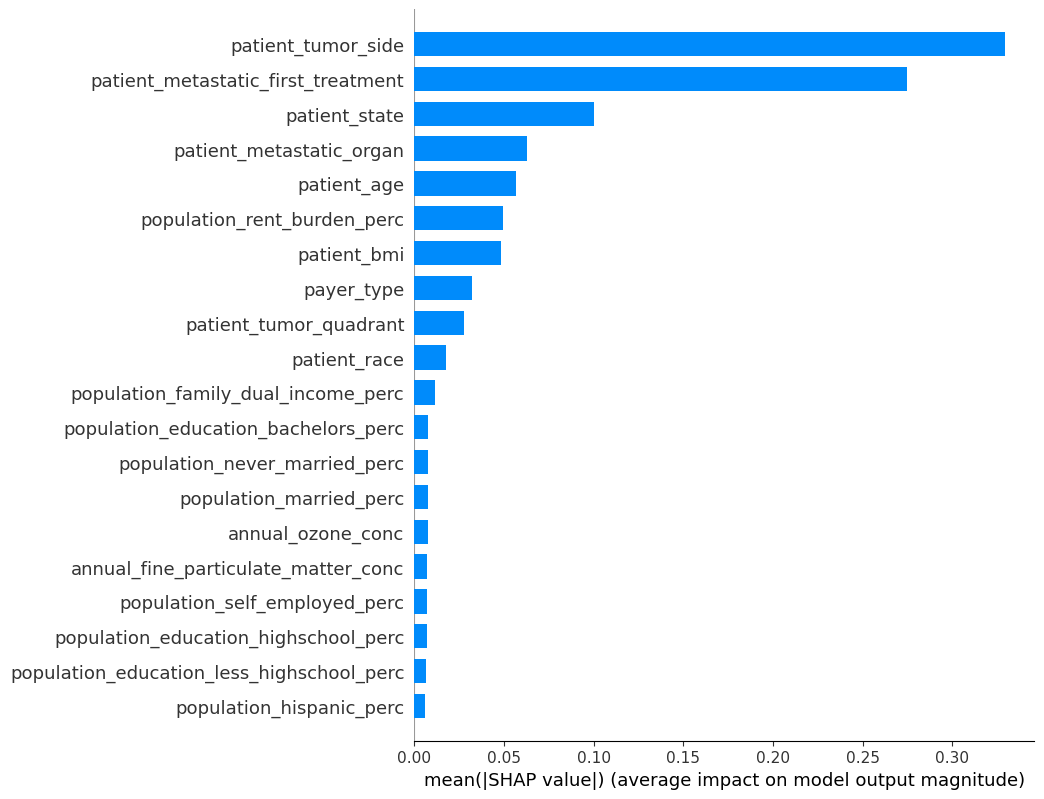

In [101]:
# Calculate shapley values for non-imputed lightGBM
explainer = shap.TreeExplainer(grid_nonimpute_30.best_estimator_)
shap_values = explainer.shap_values(X_test_nonimpute_30)
shap.summary_plot(shap_values[1], X_test_nonimpute_30, plot_type='bar')

<h4>Sensitivity analysis - Lasso imputed</h4>

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
X does not have valid feature names, but LogisticRegression was fitted with feature names
  0%|          | 0/5535 [00:00<?, ?it/s]X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
  0%|          | 1/5535 [00:00<28:28,  3.24it/s]X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
  0%|          | 2/5535 [00:00<30:32,  3.02it/s]X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
  0%|          | 3/5535 [00:00<30:04,  3.07it/s]X does not have valid feature names, but LogisticRegressi

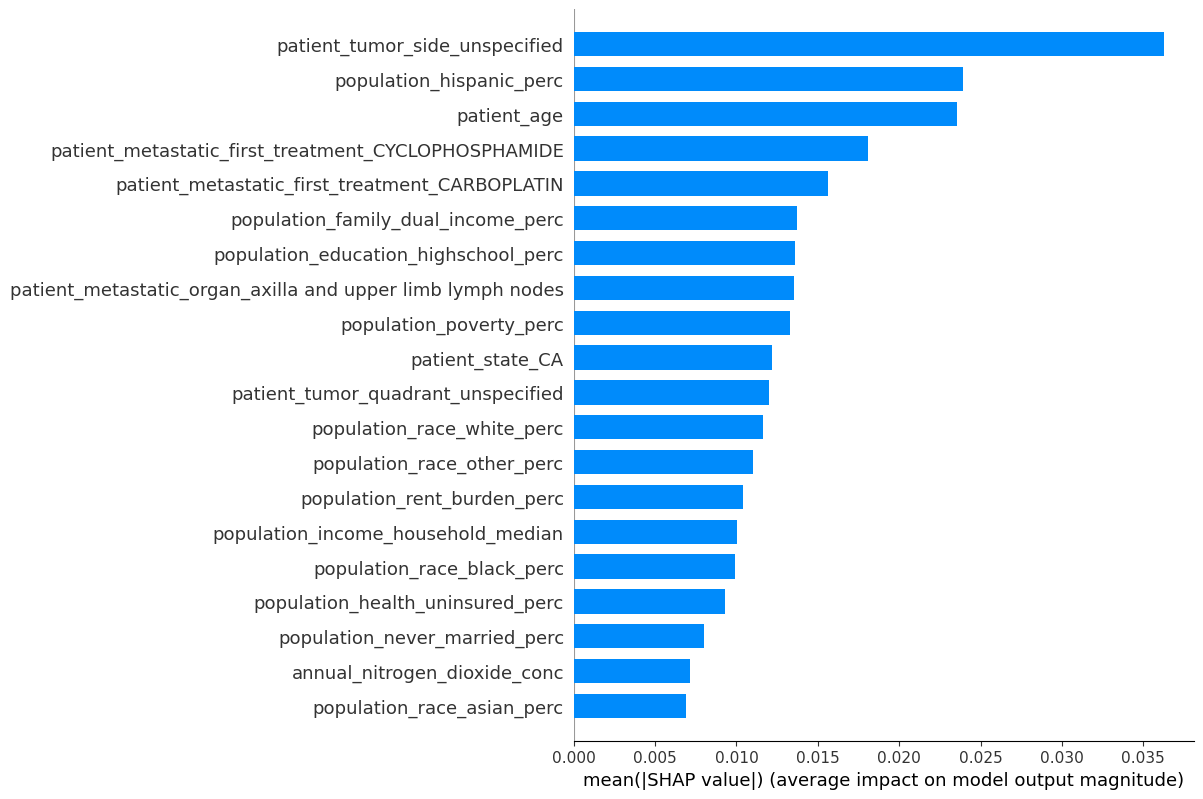

In [102]:
# Use KernelExplainer for models that are not tree-based
# Define a function that outputs the prediction probabilities
f = lambda x: l1_30.predict_proba(x)[:, 1]

# Initialize explainer object
explainer = shap.KernelExplainer(f, shap.kmeans(onehot_feat_train_impute_30, 10))

# Compute SHAP values
shap_values = explainer.shap_values(onehot_feat_test_impute_30)

# Plot the summary plot
shap.summary_plot(shap_values, onehot_feat_test_impute_30, plot_type='bar')

# Write output files for all models

In [95]:
# Write output of all models and labels to CSV

## Training data - imputed
X_train_impute_30['Y_truth_30'] = y_train_30
X_train_impute_60['Y_tuth_60'] = y_train_60
X_train_impute_90['Y_truth_90'] = y_train_90

X_train_impute_30.to_csv('../Output/train_impute_30.csv', index=False)
X_train_impute_60.to_csv('../Output/train_impute_60.csv', index=False)
X_train_impute_90.to_csv('../Output/train_impute_90.csv', index=False)

## Test data - imputed 30 day
X_test_impute_30['Y_truth_30'] = y_test_30
X_test_impute_30['y_pred_30_lgb'] = y_test_pred_impute_lgb_30
X_test_impute_30['y_pred_30_rf'] = y_test_pred_impute_rf_30
X_test_impute_30['y_pred_30_log_reg'] = y_test_pred_impute_log_reg_30
X_test_impute_30['y_pred_30_l1'] = y_test_pred_impute_l1_30

## Test data - imputed 60 day
X_test_impute_60['Y_truth_60'] = y_test_60
X_test_impute_60['y_pred_60_lgb'] = y_test_pred_impute_lgb_60
X_test_impute_60['y_pred_60_rf'] = y_test_pred_impute_rf_60
X_test_impute_60['y_pred_60_log_reg'] = y_test_pred_impute_log_reg_60
X_test_impute_60['y_pred_60_l1'] = y_test_pred_impute_l1_60

## Test data - imputed 90 day
X_test_impute_90['Y_truth_90'] = y_test_90
X_test_impute_90['y_pred_90_lgb'] = y_test_pred_impute_lgb_90
X_test_impute_90['y_pred_90_rf'] = y_test_pred_impute_rf_90
X_test_impute_90['y_pred_90_log_reg'] = y_test_pred_impute_log_reg_90
X_test_impute_90['y_pred_90_l1'] = y_test_pred_impute_l1_90

X_test_impute_30.to_csv('../Output/test_impute_30.csv', index=False)
X_test_impute_60.to_csv('../Output/test_impute_60.csv', index=False)
X_test_impute_90.to_csv('../Output/test_impute_90.csv', index=False)